In [31]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import roc_curve,roc_auc_score
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [32]:
molecule_matrix = pd.read_csv('./Dataset/Molecule_matrix_mold2.csv',dtype={'CID':'str'})

In [33]:
CID = np.array(molecule_matrix['CID'])
label = np.array(molecule_matrix['outcome'])
molecule_matrix_ = np.array(molecule_matrix.iloc[:,1:molecule_matrix.shape[1]-1])

In [34]:
label[label=='active']=1
label[label=='inactive']=0
label = label.astype('int')

In [35]:
print(molecule_matrix_.shape)
print(Counter(label))

(302630, 648)
Counter({0: 301747, 1: 883})


In [36]:
ratio = {0:8000,1:883}
rus = RandomUnderSampler(ratio=ratio, replacement=False, return_indices=True)
x_resample, y_resample, indices = rus.fit_sample(molecule_matrix_,label)

In [37]:
x_train,x_test,y_train,y_test = train_test_split(x_resample,y_resample,test_size = 0.2)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train)

In [38]:
train = xgb.DMatrix(x_train,y_train)
val = xgb.DMatrix(x_val,y_val)
test = xgb.DMatrix(x_test,y_test)

In [39]:
# set the parameters for xgboost
scale = float(np.sum(y_resample==0)/np.sum(y_resample==1))
param = {'gamma':0.8,'max_depth':6,'objective':'binary:logistic','eval_metric':'auc','scale_pos_weight':scale}
num_round = 25
watchlist = [(val,'eval'),(train,'train')]

In [40]:
# train the model
evals_result = dict()
bst = xgb.train(params=param,dtrain=train,num_boost_round=num_round,evals=watchlist,evals_result=evals_result)

[0]	eval-auc:0.710948	train-auc:0.893218
[1]	eval-auc:0.769611	train-auc:0.927395
[2]	eval-auc:0.786493	train-auc:0.942932
[3]	eval-auc:0.797648	train-auc:0.95584
[4]	eval-auc:0.802989	train-auc:0.963369
[5]	eval-auc:0.803335	train-auc:0.973047
[6]	eval-auc:0.805204	train-auc:0.977887
[7]	eval-auc:0.810867	train-auc:0.982624
[8]	eval-auc:0.817212	train-auc:0.986928
[9]	eval-auc:0.819785	train-auc:0.989016
[10]	eval-auc:0.824345	train-auc:0.991673
[11]	eval-auc:0.826888	train-auc:0.993798
[12]	eval-auc:0.828188	train-auc:0.995529
[13]	eval-auc:0.830954	train-auc:0.996079
[14]	eval-auc:0.829333	train-auc:0.996777
[15]	eval-auc:0.832792	train-auc:0.997794
[16]	eval-auc:0.832089	train-auc:0.998472
[17]	eval-auc:0.834341	train-auc:0.999298
[18]	eval-auc:0.833806	train-auc:0.999523
[19]	eval-auc:0.835198	train-auc:0.999775
[20]	eval-auc:0.834468	train-auc:0.999814
[21]	eval-auc:0.833525	train-auc:0.999811
[22]	eval-auc:0.834705	train-auc:0.999859
[23]	eval-auc:0.835034	train-auc:0.999938
[24

In [41]:
train_auc = evals_result['train']['auc']
eval_auc = evals_result['eval']['auc']

Text(0,0.5,'Area Under ROC curve')

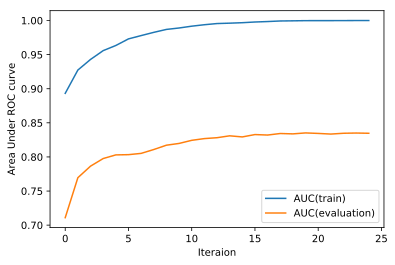

In [42]:
plt.plot(train_auc,label='AUC(train)')
plt.plot(eval_auc,label='AUC(evaluation)')
plt.legend()
plt.xlabel('Iteraion')
plt.ylabel('Area Under ROC curve')

In [43]:
# set the cut-off threshold to 0.4 
pred = bst.predict(test)
y_preds = [1 if p>0.4 else 0 for p in pred]

In [44]:
# metric measurement: 1). Accuracy 
label =  test.get_label()
print('Accuracy:', 1- np.mean(y_preds != label))

Accuracy: 0.856499718627


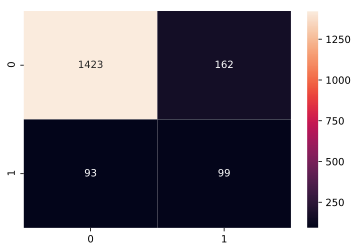

In [45]:
# 2). confustion matrix
cm = confusion_matrix(y_pred=y_preds,y_true=label)
sns.heatmap(cm,annot=True,fmt='d')

In [46]:
# 3). True positive rate and False negative rate
tn,fp,fn,tp = confusion_matrix(y_pred=y_preds,y_true=label).ravel()
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
print('True positive rate:', tpr)
print('False negative rate:', fnr)

True positive rate: 0.515625
False negative rate: 0.484375


In [47]:
# 4). auc
print('AUC:', roc_auc_score(y_true=label,y_score=pred))

AUC: 0.803111855941


In [48]:
# 5). ROC curve
fpr,tpr,thresholds = roc_curve(y_true=label,y_score=pred)

Text(0.5,1,'ROC curve')

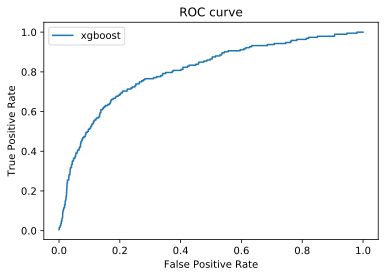

In [49]:
plt.plot(fpr,tpr,label='xgboost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')